In [568]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy.stats import norm
from scipy.special import factorial
from tqdm import tqdm

In [569]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [570]:
# Reading channels
data = pd.read_csv('datos.csv',sep=',')
n = np.array(data.n)
b = np.array(data.b)
s = np.array(data.s)
N = n.shape[0]
data

,n,b,s
0,105,100,10


In [572]:
# Estimator definition
def GetLnQ(n,b,s,mu):
    return 2*(mu*s - n*np.log( 1 + (mu*s/b) ))

In [573]:
def GetJointLnQ(LnQ,mu,Null=True):

    Q = 0.

    for c in range(N):

        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson( mu*s[c] + b[c] )

        Q += LnQ(ntoy,b[c],s[c],mu)

    return Q

In [579]:
def GetObsJointLnQ(LnQ,mu,Expected = True):

    Q = 0.
    
    for c in range(N):

        if Expected: # Observed events are the expected background
            Q += LnQ( b[c], b[c], s[c], mu )
        else:
            Q += LnQ( n[c], b[c], s[c], mu )

    return Q

In [580]:
# The observed LnQ
Qobs = GetObsJointLnQ(GetLnQ,1.0,Expected=False)
Qobs

-0.0151377589082351

In [600]:
def Sampler(mu, Ntoys = int(2e4)):

    q0 = np.zeros(Ntoys)
    q1 = np.zeros(Ntoys)

    for i in range(Ntoys):
        q0[i] = GetJointLnQ(GetLnQ, mu)  #H0
        q1[i] = GetJointLnQ(GetLnQ, mu, Null = False) #H1
    
    return q0,q1

In [601]:
q0,q1 =  Sampler(1.)

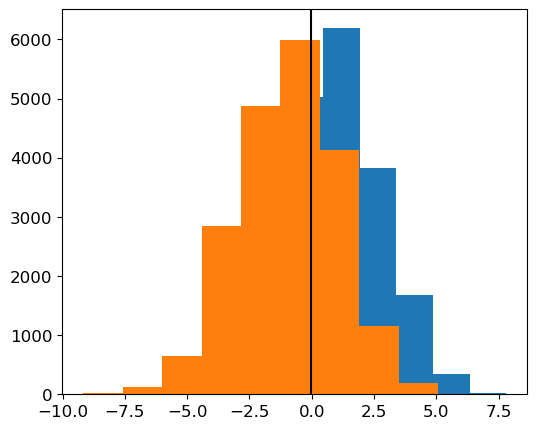

In [602]:
plt.hist(q0)
plt.hist(q1)
plt.axvline(x=Qobs,color='k')
#plt.yscale('log')

In [603]:
def GetPValue(data,Qobs, Null = True):

    if Null:
        count_below_threshold = np.sum( data <= Qobs )
        p_value = count_below_threshold/data.shape[0]

    else:
        count_above_threshold = np.sum( data >= Qobs )
        p_value = count_above_threshold / data.shape[0]

    return p_value

In [604]:
p0 = GetPValue(q0,Qobs,Null = True)
p1 = GetPValue(q1,Qobs,Null = False)
print(p0,p1)

0.3219 0.34395


In [605]:
Clsb = p1
Clb = 1 - p0
print(Clb,Clsb)

0.6780999999999999 0.34395


In [606]:
Cls = Clsb/Clb
Cls

0.507226072850612

In [607]:
mu = np.linspace(0.5,3,20)

In [608]:
# p-value scan
def GetCls(mu,Expected=False):

    p_value = np.zeros_like(mu)

    for i in tqdm(range(mu.shape[0])):

        Qobs = GetObsJointLnQ(GetLnQ,mu[i],Expected)
        q0,q1 = Sampler(mu[i])

        p0 = GetPValue(q0,Qobs,Null = True)
        p1 = GetPValue(q1,Qobs,Null = False)

        Clb = 1 - p0
        Clsb = p1
        
        Clsb = Clsb/Clb

        p_value[i] = Clsb

    return p_value

In [609]:
Op_value = GetCls(mu,Expected=False)
Ep_value = GetCls(mu,Expected=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.98it/s]


In [610]:
# Falta Upper Limit

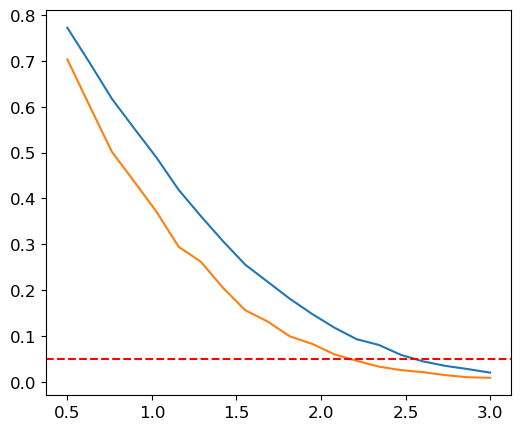

In [611]:
plt.plot(mu,Op_value)
plt.plot(mu,Ep_value)
plt.axhline(y=0.05,ls='--',color='r')